In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tetris/Torch')
# from dqn_agent import DQNAgent
# from tetrisActions import Tetris as TetrisA
# from tetrisb import Tetris as TetrisB

import os
import pickle
import time
from datetime import datetime
from statistics import mean, median
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from collections import deque

from tetris import Tetris as TetrisA
from tetrisb import Tetris as TetrisB

from plotting import modified_plot,simple_plot


In [ ]:
env_name='SmallBoard'
algo='DQNBoard'
Rew_Fun='Reward_A'
big=False
see_piece=True

ROOT  :: 
 /content/gdrive/MyDrive/Tetris/Torch/Runs/DQNBoard/SmallBoard/Reward_A/Tue Aug 10 12 47 03 2021
Hyperparameters :: Starting model = 0,    epsilon = 0.9,     Learing Rate = 0.0001,     gamma = 0.99,     epsilon_greedy_frames = 50000,    epsilon_random_frames =1000,    epsilon_min = 0.1,    max_memory_length = 100000,    update_network = 1000,     batch_size =32,    Total Games =15000,    num_actions=1,      See Piece=True


Mean Score ::  23.11 Best Score ::  53.5  -- Max Score ::  158
Mean Lines Cleared ::  1.626
...saving checkpoint...
...saving checkpoint...
Mean Score ::  36.508 Best Score ::  82.4  -- Max Score ::  298
Mean Lines Cleared ::  2.882
...saving checkpoint...
...saving checkpoint...
Mean Score ::  109.662 Best Score ::  316.2  -- Max Score ::  1130
Mean Lines Cleared ::  9.386
...saving checkpoint...
...saving checkpoint...
Mean Score ::  233.535 Best Score ::  458.8  -- Max Score ::  1917
Mean Lines Cleared ::  18.476
...saving checkpoint...
...saving checkpoint...
Mean Score ::  170.209 Best Score ::  458.8  -- Max Score ::  1917
Mean Lines Cleared ::  13.211
...saving checkpoint...
...saving checkpoint...
Mean Score ::  160.527 Best Score ::  458.8  -- Max Score ::  1917
Mean Lines Cleared ::  12.839
...saving checkpoint...
...saving checkpoint...
Mean Score ::  157.769 Best Score ::  458.8  -- Max Score ::  1917
Mean Lines Cleared ::  12.645
...saving checkpoint...
...saving checkpoin

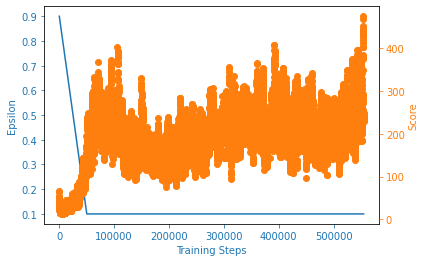

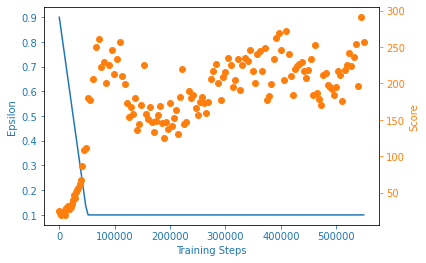

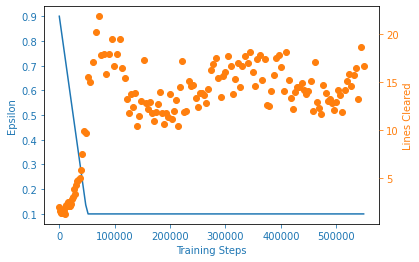

In [ ]:
load_checkpoint=False
baseRoot='/content/gdrive/MyDrive/Tetris/Torch/Runs'

if env_name=='FullBoard':
    env=TetrisA(Rew_Fun)
elif env_name=='SmallBoard':
    env=TetrisB(Rew_Fun)
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

if algo=='DQNBoard':
    from DQNBoardAgent import DQNAgent
elif algo=='DuellingDQNBoard':
    from DuellingDQNBoardAgent import DuellingDQNAgent as DQNAgent
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

board_dim=np.expand_dims(np.array(env.board),axis=0).shape
### 10k episodes -- 200k frames
### 100k episodes --- 2m frames
if not load_checkpoint:
    if big:
      start=0
      n_games=300_000
      epsilon=0.99
      gamma = 0.99
      lr=0.0001
      epsilon_greedy_frames = 5_000_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 200_000
      update_network =5000
      batch_size =32
      num_actions=1

      stepping=1000
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
              epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']
    else:
      start=0
      n_games=15_000
      epsilon=0.9
      gamma = 0.99
      lr=0.0001
      epsilon_greedy_frames = 50_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 100_000
      update_network = 1000
      batch_size =32
      num_actions=1
      stepping=100
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
              epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']

    baseRoot=os.path.join(baseRoot,algo)
    if os.path.isdir(baseRoot):
        baseRoot=os.path.join(baseRoot,env_name)
        if os.path.isdir(baseRoot):
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            if os.path.isdir(baseRoot):
              pass
            else:
              os.mkdir(baseRoot)
        else:
            os.mkdir(baseRoot)
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            os.mkdir(baseRoot)
    else:
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,env_name)
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,Rew_Fun)
        os.mkdir(baseRoot)

    #baseRoot= os.path.join(cwd,algo,env_name,"Runs")

    #baseRoot= "app/"+algo+"/"+env_name+"/Runs/"

    t = time.localtime()
    current_time = time.asctime(t)
    current_time=current_time.replace(':',' ')
    Root=os.path.join(baseRoot,str(current_time))

    os.mkdir(Root)
    print('ROOT  :: \n',Root)
    os.mkdir(Root+'/logs')
    os.mkdir(Root+'/models')
    os.mkdir(Root+'/buffer')
    os.mkdir(Root+'/statistics')
    log_summaries='/logs/summaries'
    log_trainings='/logs/training'
    with open(Root+log_trainings+'.txt','w') as c:
      c.write(f'Hyperparameters :: Starting model = {start},\
      epsilon = {epsilon}, \
      Learing Rate = {lr}, \
      gamma = {gamma}, \
      epsilon_greedy_frames = {epsilon_greedy_frames},\
      epsilon_random_frames ={epsilon_random_frames},\
      epsilon_min = {epsilon_min},\
      max_memory_length = {max_memory_length},\
      update_network = {update_network}, \
      batch_size ={batch_size},\
      Total Games ={n_games},\
      num_actions={num_actions},\
      See Piece={see_piece}')
      c.write('\n')
    pickle.dump( parameters, open( Root+'/hyperparameters.p', "wb" ))
    print(f'Hyperparameters :: Starting model = {start},\
    epsilon = {epsilon}, \
    Learing Rate = {lr}, \
    gamma = {gamma}, \
    epsilon_greedy_frames = {epsilon_greedy_frames},\
    epsilon_random_frames ={epsilon_random_frames},\
    epsilon_min = {epsilon_min},\
    max_memory_length = {max_memory_length},\
    update_network = {update_network}, \
    batch_size ={batch_size},\
    Total Games ={n_games},\
    num_actions={num_actions},\
      See Piece={see_piece}')
    best_score=0
    max_score=0
    scores, eps_history, steps_array,stats,lines_c = [], [], [],[],[]
    latest_Root=Root

    agent=DQNAgent(dims=board_dim,
             epsilon =epsilon, gamma = gamma,lr=lr,
             epsilon_greedy_frames = epsilon_greedy_frames,
             epsilon_random_frames =epsilon_random_frames,
             epsilon_min = epsilon_min,
             max_memory_length = max_memory_length,
             update_network = update_network,
             batch_size =batch_size,num_actions=num_actions,
             algo=algo,
             chkpt_dir=Root,
             env_name=env_name)
   
else:
  Root=latest_Root
  #Root='/content/gdrive/MyDrive/Tetris/Torch/Runs/DDuellingDQNActions/SmallBoard/Tue Aug  3 15 28 29 2021Changed_Reward'
  log_summaries='/logs/summaries'
  log_trainings='/logs/training'
  parameters=pickle.load(open(Root+'/hyperparameters.p','rb'))
  start=pickle.load(open(Root+'/statistics/episode.p','rb'))
  
  n_games=parameters[1]
  n_games=4000

  epsilon=parameters[2]
  gamma=parameters[3]
  lr=parameters[4]
  epsilon_greedy_frames=parameters[5]
  epsilon_random_frames=parameters[6]
  epsilon_min=parameters[7]
  max_memory_length=parameters[8]
  update_network=parameters[9]
  batch_size=parameters[10]
  num_actions=parameters[11]
  stepping=parameters[12]
  see_piece=parameters[13]

  best_score=0
  max_score=0
  scores=pickle.load( open( Root+'/statistics/scores.p', "rb" ))
  stats=pickle.load( open( Root+'/statistics/summary.p', "rb" ))
  steps_array=pickle.load( open( Root+'/statistics/steps.p', "rb" ))
  eps_history=pickle.load( open( Root+'/statistics/eps_history.p', "rb" ))
  lines_c=pickle.load( open( Root+'/statistics/lines_cleared.p', "rb" ))
  agent=DQNAgent(dims=board_dim,
          epsilon =epsilon, gamma = gamma,lr=lr,
          epsilon_greedy_frames = epsilon_greedy_frames,
          epsilon_random_frames =epsilon_random_frames,
          epsilon_min = epsilon_min,
          max_memory_length = max_memory_length,
          update_network = update_network,
          batch_size =batch_size,num_actions=num_actions,
          algo=algo,
          chkpt_dir=Root,
          env_name=env_name)
  agent.frames=steps_array[-1]
  agent.epsilon=eps_history[-1]
  agent.load_models(start)
  agent.memory.load_buffer(Root)

  print('LOADED CHECKPOINT')
  print('ROOT  :: \n',Root)
  print(f'Hyperparameters :: Starting model = {start},\
  epsilon = {epsilon}, \
  Learing Rate = {lr}, \
  gamma = {gamma}, \
  epsilon_greedy_frames = {epsilon_greedy_frames},\
  epsilon_random_frames ={epsilon_random_frames},\
  epsilon_min = {epsilon_min},\
  max_memory_length = {max_memory_length},\
  update_network = {update_network}, \
  batch_size ={batch_size},\
  Total Games ={n_games},\
  num_actions={num_actions},\
  See Piece={see_piece}')

for episode in tqdm(range(start+1,n_games+1)):
    env.reset()
    if see_piece:
      current_state=env._get_complete_board()
    else:
      current_state=env.board
    done = False
    score=0
    tops=1000
    lines=0
    while not done :
        dic=env.get_next_boards()
        action=agent.choose_action(dic)
        reward, done,lc = env.play(action[0],action[1], render=False,
                              render_delay=0)
        if see_piece:
          next_state=env._get_complete_board()
        else:
          next_state=dic[action]
        
        agent.store_transition(current_state,reward,next_state,done)
        agent.learn()
        current_state=next_state
        score+=reward
        lines+=lc
        if (score >tops):
            tops+=1000
            with open(Root+log_trainings+'.txt','a') as c:
              c.write(f'Score : {score} ')
              c.write('\n')
    scores.append(score)
    lines_c.append(lines)
    if score > max_score:
      max_score=score
    steps_array.append(agent.frames)
    eps_history.append(agent.epsilon)
    if episode % 10 == 0:
        avg_score = np.mean(scores[-10:])
        if avg_score>best_score:
            best_score=avg_score
        t = time.localtime()
        current_time = time.strftime("%H:%M:%S", t)
        with open(Root+log_trainings+'.txt','a') as c:
            c.write(f'episode: {episode} ,score: , {score}, lines cleared:{lines}\
average score {avg_score}, best score {best_score},\
epsilon {agent.epsilon},steps {agent.frames} ,time : {current_time}')
            c.write('\n')
    if (episode % 100)==0:
        summary={}
        summary['min'] = np.min(scores[-100:])
        summary['max'] = np.max(scores[-100:])
        summary['mean'] = np.mean(scores[-100:])
        stats.append(summary)
    if (episode % 1000)==0:
        print('Mean Score :: ',np.mean(scores[-1000:]),'Best Score :: ',best_score,' -- Max Score :: ',max_score)
        print('Mean Lines Cleared :: ',np.mean(lines_c[-1000:]))
        agent.save_models(episode)
    if (episode % 10000)==0:
        agent.memory.save_buffer(Root)
        pickle.dump( scores, open( Root+'/statistics/scores.p', "wb" ))
        pickle.dump( stats, open( Root+'/statistics/summary.p', "wb" ))
        pickle.dump( steps_array, open( Root+'/statistics/steps.p', "wb" ))
        pickle.dump( eps_history, open( Root+'/statistics/eps_history.p', "wb" ))
        pickle.dump( lines_c, open( Root+'/statistics/lines_cleared.p', "wb" ))
        pickle.dump(episode, open( Root+'/statistics/episode.p', "wb" ))

modified_plot(steps_array, scores, eps_history, Root+'/learning_score.png',stepping,'Score')
modified_plot(steps_array, lines_c, eps_history, Root+'/learning_lines.png',stepping,'Lines Cleared')